# **Seq2Seq Model**

In [ ]:
!sudo apt-get install cuda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install nltk
!pip install torch==1.0.0
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pandas

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import pickle
import collections
from pandas.io.json import json_normalize
import torch
from torch import nn
import re, os, string, typing, gc, json
import spacy
from collections import Counter
import time
from torch import optim
import random
nlp = spacy.load('en_core_web_sm', exclude = 'tagger, parser, ner')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

In [ ]:
data=json.load((open('coqa-train-v1.0.json')))
ans=json_normalize(data['data'], ['answers'],['id'])
ans['id'] = ans.apply(lambda row: row.id + str(row.turn_id), axis=1)
train_df=ans[['id','span_text','input_text']]
train_df.rename({'span_text':'X_train','input_text':'Y_train'}, axis=1, inplace=True)
train_df.head()


In [ ]:
data=json.load((open('coqa-dev-v1.0.json')))
ans=json_normalize(data['data'], ['answers'],['id'])
ans['id'] = ans.apply(lambda row: row.id + str(row.turn_id), axis=1)
valid_df=ans[['id','span_text','input_text']]
valid_df.rename({'span_text':'X_train','input_text':'Y_train'}, axis=1, inplace=True)
valid_df.head()

In [ ]:
def normalize_spaces(text):
    '''
    Removes extra white spaces from the context.
    '''
    text = re.sub(r'\s', ' ', text)
    return text

train_df.X_train = train_df.X_train.apply(normalize_spaces)
train_df.Y_train = train_df.Y_train.apply(normalize_spaces)

valid_df.X_train = valid_df.X_train.apply(normalize_spaces)
valid_df.Y_train = valid_df.Y_train.apply(normalize_spaces)


In [ ]:
train_df=train_df[:10000]

In [ ]:
def gather_text_for_vocab(dfs:list):
    '''
    Gathers text from contexts and questions to build a vocabulary.
    
    :param dfs: list of dataframes of CoQA dataset.
    :returns: list of contexts and questions
    '''
    
    text = []
    total = 0
    for df in dfs:
        unique_spans = list(df.X_train.unique())
        unique_answers = list(df.Y_train.unique())
        total += df.X_train.nunique() + df.Y_train.nunique()
        text.extend(unique_spans + unique_answers)
    
    assert len(text) == total
    
    return text
    
# gather text to build vocabularies

%time vocab_text = gather_text_for_vocab([train_df, valid_df])
print("Number of sentences in dataset: ", len(vocab_text))

In [ ]:
def build_word_vocab(vocab_text):
    '''
    Builds a word-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict word2idx: word to index mapping of words
        dict idx2word: integer to word mapping
        list word_vocab: list of words sorted by frequency
    '''
    
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser','tagger','ner']):
            words.append(word.text)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    print(f"raw-vocab: {len(word_vocab)}")
    #word_vocab = list(set(word_vocab).intersection(set(glove_words)))
    print(f"glove-vocab: {len(word_vocab)}")
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    print(f"vocab-length: {len(word_vocab)}")
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    print(f"word2idx-length: {len(word2idx)}")
    idx2word = {v:k for k,v in word2idx.items()}
    
    
    return word2idx, idx2word, word_vocab

# build word vocabulary

%time word2idx, idx2word, word_vocab = build_word_vocab(vocab_text)

In [ ]:
def build_char_vocab(vocab_text):
    '''
    Builds a character-level vocabulary from the given text.
    
    :param list vocab_text: list of contexts and questions
    :returns 
        dict char2idx: character to index mapping of words
        list char_vocab: list of characters sorted by frequency
    '''
    
    chars = []
    for sent in vocab_text:
        for ch in sent:
            chars.append(ch)

    char_counter = Counter(chars)
    char_vocab = sorted(char_counter, key=char_counter.get, reverse=True)
    print(f"raw-char-vocab: {len(char_vocab)}")
    high_freq_char = [char for char, count in char_counter.items() if count>=20]
    char_vocab = list(set(char_vocab).intersection(set(high_freq_char)))
    print(f"char-vocab-intersect: {len(char_vocab)}")
    char_vocab.insert(0,'<unk>')
    char_vocab.insert(1,'<pad>')
    char2idx = {char:idx for idx, char in enumerate(char_vocab)}
    print(f"char2idx-length: {len(char2idx)}")
    
    return char2idx, char_vocab

In [ ]:
def context_to_ids(text, word2idx):
    '''
    Converts context text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: context text to be converted
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''

    context_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    context_ids = [word2idx[word] for word in context_tokens]
    
    assert len(context_ids) == len(context_tokens)
    return context_ids
    
def question_to_ids(text, word2idx):
    '''
    Converts question text to their respective ids by mapping each word
    using word2idx. Input text is tokenized using spacy tokenizer first.
    
    :param str text: question text to be converted
    :returns list context_ids: list of mapped ids
    
    :raises assertion error: sanity check
    
    '''

    question_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    question_ids = [word2idx[word] for word in question_tokens]
    
    assert len(question_ids) == len(question_tokens)
    return question_ids

In [ ]:
# numericalize context and questions for training and validation set

%time train_df['X_train_ids'] = train_df.X_train.apply(context_to_ids, word2idx=word2idx)
%time valid_df['X_train_ids'] = valid_df.X_train.apply(context_to_ids, word2idx=word2idx)

%time train_df['Y_train_ids'] = train_df.Y_train.apply(question_to_ids,  word2idx=word2idx)
%time valid_df['Y_train_ids'] = valid_df.Y_train.apply(question_to_ids,  word2idx=word2idx)

In [ ]:
X_train_ids=[]
for index,row in train_df.iterrows():
    X_train_ids.append(row[3])
Y_train_ids=[]
for index,row in train_df.iterrows():
    Y_train_ids.append(row[4])

In [ ]:
vocab_size=0
for index,row in train_df.iterrows():
  vocab_size=max(vocab_size,max(row[3]))
print(vocab_size)

In [ ]:
for index,row in valid_df.iterrows():
  vocab_size=max(vocab_size,max(row[3]))
print(vocab_size)

Converting both X_train and Y_train to same size of length 128

In [ ]:
N=128
for i in range(len(X_train_ids)):
  if len(X_train_ids[i])>N:
    X_train_ids[i]=X_train_ids[i][:N]
  else:
    X_train_ids[i]+=[1] * (N - len(X_train_ids[i]))

In [ ]:
N=128
for i in range(len(Y_train_ids)):
  if len(Y_train_ids[i])>N:
    Y_train_ids[i]=Y_train_ids[i][:N]
    print(len(Y_train_ids[i]))
  else:
    Y_train_ids[i]+=[1] * (N - len(Y_train_ids[i]))

Making pairs of each X_Train and Y_train

In [ ]:
pairs=[]
for i in range(len(X_train_ids)):
    pairs.append((X_train_ids[i], Y_train_ids[i]))

Converting X_Triain and Y_train to tensors

In [ ]:
X = torch.tensor(X_train_ids, dtype=torch.long).view(-1,1)
Y = torch.tensor(Y_train_ids, dtype=torch.long).view(-1,1)

# **Model**

A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.


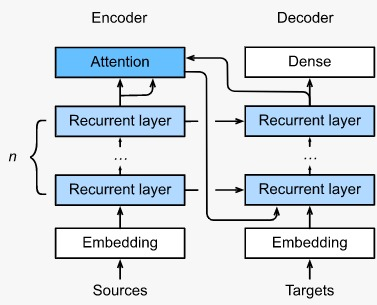

**Encoder**:

Encoder is a RNN that outputs some value for every word in input sentence. For every input word, the encoder outputs a vector and a hidden state. The hidden state is used along with the  next input word.

In [ ]:
##Seq-to-seq Encoder-Decoder layers

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Decoder**:

Decoder takes the context vector as the input to the first decoder unit. Then, the output of every decoder is taken as input to the next decoder unit to produce one sentence.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Attention**:

Attention helps decoder to choose the right output word and to focus only on a specific range in input sequence.


In [ ]:
MAX_LENGTH=10
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Teacher Forcing**:

We use real target outputs as each next input instead  of using decoder's guess as the next input

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor(device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

**Helper Functions**:

This is a helper function to print time elapsed and estimated time remaining given the current time and progress percentage.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**Training**:

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss. This method will train and generate predictions which we save as result.json file.

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=10, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        preds = evaluate(encoder1, attn_decoder1)

        p1, p2 = preds
        for i in range(batch_size):
            predictions={}
            id = ids[i][:30]
            turn_id=ids[i][30:]
            pred = context[i][s_idx[i]:e_idx[i]+1]
            pred = ' '.join([idx2word[idx.item()] for idx in pred])
            predictions['id'] = id
            predictions['turn_id']=int(turn_id)
            predictions['answer']=pred
            prediction.append(predictions)
            
            
        with open('result-{}.json'.format(epoch), 'w') as fp:
            json.dump(prediction, fp)
        print('result saved')         

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

**Evaluation**:

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. 

Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Initialize the Encode and Attention Decoder with hidden size of 128. Then run the model for 10 epochs , result will get saved as result.json.

In [ ]:
hidden_size = 128
encoder1 = EncoderRNN(1000, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, 18692, dropout_p=0.4).to(device)

import time
import torch.nn.functional as F
train_losses = []
valid_losses = []
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    start_time = time.time()
    
    train_loss = trainIters(encoder1, attn_decoder1, 750, print_every=5000)
    valid(model, valid_dataset)